# Stephen Curry 2024-25 Shooting Analysis

Author: 劉豐睿 (Feng-Jui Liu)  
Date: 2025-11-17 

This notebook analyzes Stephen Curry's 2024-25 regular season field goal attempts using the official NBA Stats API (`nba_api`).  
I build a reproducible pipeline to fetch shot data, visualize the shot chart, and compute zone-wise shooting efficiency.

In [1]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = (6, 6)

def draw_court(ax=None, color="black", lw=1):
    if ax is None:
        ax = plt.gca()

    court_width = 500
    half_court_len = 470
    paint_width = 160
    paint_height = 190
    FT_RADIUS = 30
    FT_CENTER_Y = 190
    corner_three_height = 90
    three_radius = 238

    hoop = patches.Circle((0, 0), radius=7.5, color=color, fill=False, lw=lw)
    paint = patches.Rectangle((-paint_width/2, 0), paint_width, paint_height, fill=False, lw=lw, color=color)
    ft_circle = patches.Circle((0, FT_CENTER_Y), FT_RADIUS, fill=False, lw=lw, color=color)
    corner_left = patches.Rectangle((-220, 0), 0, corner_three_height, lw=lw, color=color, fill=False)
    corner_right = patches.Rectangle((220, 0), 0, corner_three_height, lw=lw, color=color, fill=False)
    three_arc = patches.Arc((0, 0), 2*three_radius, 2*three_radius, theta1=22, theta2=158, lw=lw, color=color)
    outer = patches.Rectangle((-court_width/2, 0), court_width, half_court_len, lw=lw, fill=False, color=color)

    for e in [hoop, paint, ft_circle, corner_left, corner_right, three_arc, outer]:
        ax.add_patch(e)

    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    ax.set_aspect('equal', adjustable='box')
    return ax

/Users/fengjui/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


 ## 1. Fetch shot data from NBA Stats API

In [2]:
# 找到 Curry 的 player_id
player_dict = players.get_players()
curry = [p for p in player_dict if p['full_name'] == "Stephen Curry"][0]
curry_id = curry['id']
curry_id

201939

In [3]:
shotchart = shotchartdetail.ShotChartDetail(
    player_id=curry_id,
    team_id=1610612744,               # GSW
    season_type_all_star='Regular Season',
    season_nullable='2024-25',
    context_measure_simple='FGA'      # 以出手為單位
)

df = shotchart.get_data_frames()[0]
df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022400007,12,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,28,...,Left Side Center(LC),24+ ft.,25,-199,157,1,1,20241112,GSW,DAL
1,Shot Chart Detail,0022400007,37,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,14,...,Center(C),Less Than 8 ft.,3,-34,15,1,1,20241112,GSW,DAL
2,Shot Chart Detail,0022400007,42,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,0,...,Right Side Center(RC),24+ ft.,29,179,237,1,0,20241112,GSW,DAL
3,Shot Chart Detail,0022400007,94,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,22,...,Left Side Center(LC),24+ ft.,31,-175,264,1,1,20241112,GSW,DAL
4,Shot Chart Detail,0022400007,121,201939,Stephen Curry,1610612744,Golden State Warriors,1,4,26,...,Right Side(R),8-16 ft.,14,137,36,1,0,20241112,GSW,DAL


## 2. Data overview

In [4]:
print("Number of shots:", len(df))
df.columns

Number of shots: 1258


Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

## 3. Zone-wise shooting summary

In [6]:
df['IS_MADE'] = df['EVENT_TYPE'] == 'Made Shot'

def calc_fg(data):
    att = len(data)
    made = data['IS_MADE'].sum()
    fg_pct = made / att if att > 0 else 0
    return att, made, fg_pct

rows = []

att, made, pct = calc_fg(df)
rows.append(["Overall", att, made, pct])

is_three = df['SHOT_TYPE'].str.contains("3PT")
att, made, pct = calc_fg(df[is_three])
rows.append(["3PT", att, made, pct])

att, made, pct = calc_fg(df[~is_three])
rows.append(["2PT", att, made, pct])

att, made, pct = calc_fg(df[df['SHOT_ZONE_BASIC'] == "Restricted Area"])
rows.append(["Restricted Area", att, made, pct])

att, made, pct = calc_fg(df[df['SHOT_ZONE_BASIC'] == "In The Paint (Non-RA)"])
rows.append(["In The Paint (Non-RA)", att, made, pct])

att, made, pct = calc_fg(df[df['SHOT_ZONE_BASIC'] == "Mid-Range"])
rows.append(["Mid-Range", att, made, pct])

summary_df = pd.DataFrame(rows, columns=["Zone", "Att", "Made", "FG%"])
summary_df["FG%"] = (summary_df["FG%"] * 100).round(1)
summary_df
summary_df.to_csv("../curry_2024_25_shooting_summary.csv", index=False)

## 4. Shot chart visualization

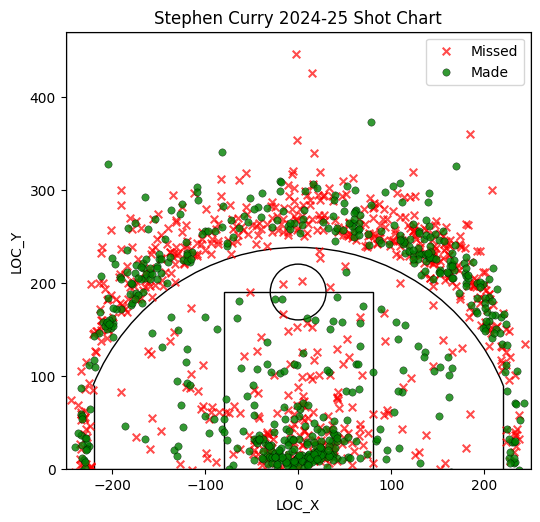

In [7]:
made_shots = df[df['EVENT_TYPE'] == 'Made Shot']
missed_shots = df[df['EVENT_TYPE'] == 'Missed Shot']

fig, ax = plt.subplots()
draw_court(ax)

ax.scatter(
    missed_shots['LOC_X'], missed_shots['LOC_Y'],
    s=30, alpha=0.7, c='red', marker='x', label='Missed', zorder=1
)
ax.scatter(
    made_shots['LOC_X'], made_shots['LOC_Y'],
    s=28, alpha=0.8, c='green',
    edgecolors='black', linewidths=0.3,
    marker='o', label='Made', zorder=2
)

ax.set_title("Stephen Curry 2024-25 Shot Chart")
ax.set_xlabel("LOC_X")
ax.set_ylabel("LOC_Y")
ax.legend()
plt.show()

## 5. Key insights

- Overall FG%: 44.8% on 1258 attempts.  
- 3PT: 39.7% on 784 attempts. 
- 2PT: 53.4% on 474 attempts.  
- Restricted Area: 64.2% – elite finishing at the rim.  
- In The Paint (Non-RA): 46.2% – mostly floaters and runners.  
- Mid-Range: 50.0% on relatively low volume.

These results match Curry's known shooting profile: heavy 3-point volume, high rim efficiency, and selective mid-range usage.